# Euler characteristic integration error behaviour

In [1]:
from itertools import combinations
from copy import deepcopy
import numpy
from numpy.linalg import norm
from numpy.random import rand

from sensorplayground import SimpleSensor, EulerEstimator, drawField, zipboth
from simplicial import SimplicialComplex, Embedding, EulerIntegrator, k_simplex, TriangularLattice, TriangularLatticeEmbedding
from simplicial.drawing import drawComplex, drawEulerIntegral

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Polygon, PathPatch
from matplotlib.path import Path
from mpl_toolkits.mplot3d.art3d import patch_collection_2d_to_3d

plt.style.use(['default', 'display.mplstyle'])

In [2]:
palette = ['w', 'r', 'b']

In [3]:
def offset(pos, s, off):
    '''Return a point offset from a sensor's position.

    :param pos: the embedding
    :param s: the simplex
    :param off: the offset
    :returns: the position'''
    return list(map(lambda po: po[0] + po[1], zip(pos[s], off)))

In [4]:
lattice = TriangularLattice(9, 3)
pos = TriangularLatticeEmbedding(lattice, h=0.8, w=0.8)

# pre-compute positions
_ = pos.positionsOf()

# offset all simplices within the field
for i in lattice.simplicesOfOrder(0):
    pos.positionSimplex(i, offset(pos, i, (0.15, 0.1)))

In [5]:
# remove simplices for fig 1
lattice.deleteSimplices([0, 1, 2])
lattice.deleteSimplices([4, 5])
lattice.deleteSimplices([18])
lattice.deleteSimplices([24, 25])

In [6]:
latticeSensors = []
for i in lattice.simplicesOfOrder(0):
    s = SimpleSensor((pos[i][0], pos[i][1]), 0.15, id=i)
    latticeSensors.append(s)

In [7]:
def makeObservations(ss, ts, c, attr = 'count'):
    '''Make obsevrations of targets from sensors and insert
    the counts into the overhearing complex.

    :param ss: the sensors
    :param ts: the targets
    :param c: the complex
    :param attr: the attribute holding the count (default 'count')'''

    # record the counts
    for s in ss:
        n = s.counts(ts)

        # record the count in an attribute of the overhearing complex
        c[s.id()][attr] = n

    # propagate the counts to higher simplices
    for k in range(1, c.maxOrder() + 1):
        for s in c.simplicesOfOrder(k):
            c[s][attr] = min([c[f][attr] for f in c.faces(s)])

In [8]:
integrator = EulerIntegrator('count')

## Micro examples

### One triangle, two targets

In [9]:
oneTriangle = SimplicialComplex()

# add a single triangle (2-simplex)
oneTriangle.addSimplicesFrom(k_simplex(2))
tri1 = oneTriangle.simplicesOfOrder(2)[0]

# position in a triangle
pos1 = {}
ss = list(oneTriangle.basisOf(tri1))
pos1[ss[0]] = (0.4, 0.4)
pos1[ss[1]] = (0.4, 0.5)
pos1[ss[2]] = (0.5, 0.4)

# place sensors at the 0-simplex points
oneTriangleSensors = []
for i in oneTriangle.simplicesOfOrder(0):
    s = SimpleSensor(pos1[i], 0.15, id=i)
    oneTriangleSensors.append(s)

Add two targets in the same triangle.

In [10]:
t1 = offset(pos1, ss[0], (0.02, 0.02))
t2 = offset(pos1, ss[1], (0.02, -0.02))

In [11]:
makeObservations(oneTriangleSensors, [t1, t2], oneTriangle)

count = integrator.integrate(oneTriangle)
print(f'Counting {count} targets')

Counting 2 targets


### Two triangles, two targets

Now let us create as network with two triangles and one target in each.

In [12]:
twoTriangle = oneTriangle.copy()

# add a second triangle
ss = list(oneTriangle.basisOf(tri1))
n4 = twoTriangle.addSimplex(fs=[])
tri2 = twoTriangle.addSimplexWithBasis(bs=[ss[1], ss[2], n4])
pos2 = deepcopy(pos1)
pos2[n4] = (0.5, 0.5)
twoTriangleSensors = deepcopy(oneTriangleSensors)
s = SimpleSensor(pos2[n4], 0.15, id=n4)
twoTriangleSensors.append(s)

In [13]:
t3 = offset(pos2, n4, (-0.02, -0.02))

In [14]:
makeObservations(twoTriangleSensors, [t1, t2], twoTriangle)

count = integrator.integrate(twoTriangle)
print(f'Counting {count} targets')

Counting 2 targets


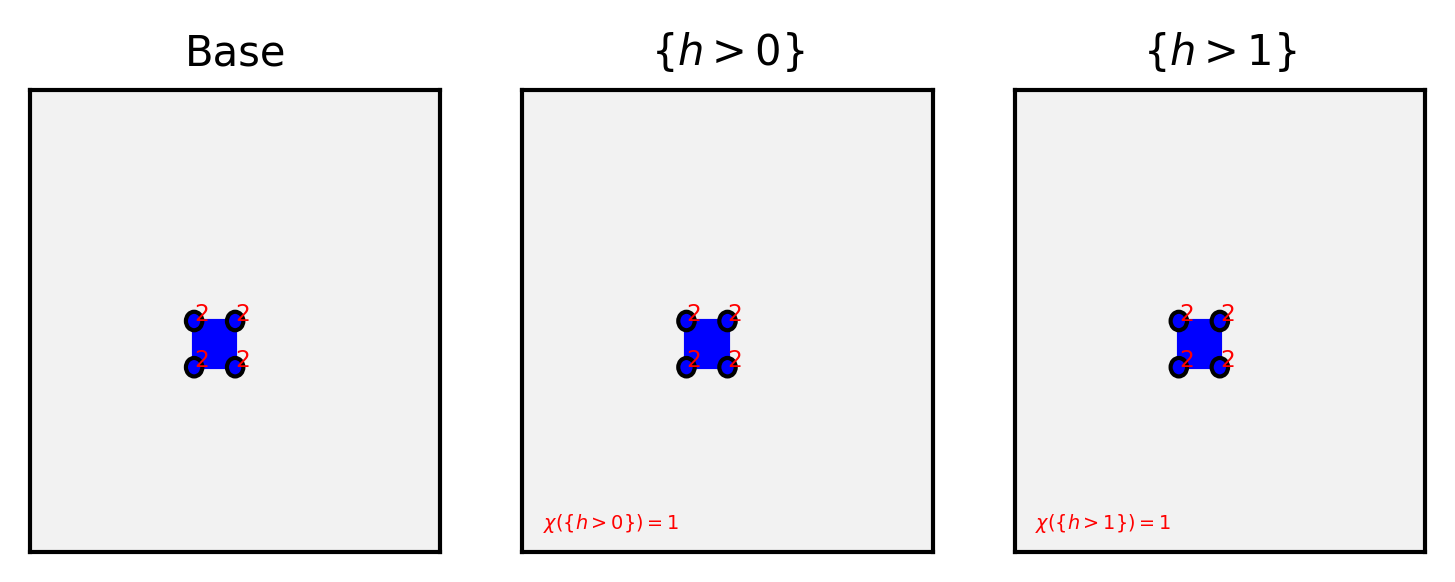

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 2))
drawEulerIntegral(twoTriangle, pos2, axs=axs,
                  showLevelSets=True,
                  showEulerCharacteristics=True, eulerCharacteristicsColour='r', eulerCharacteristicsFontSize='xx-small',
                  showMetrics=True, metricsColour='r', metricsFontSize='x-small',
                  simplexColour=lambda c, s, k: palette[twoTriangle[s]['count']])
plt.show()

Essentially the shape of the overhearing complex is a "tower" of height 2.

### One tetrahedron with targets in two different triangles

In [20]:
oneTetra = SimplicialComplex()

# add a single tetrahedron (3-simplex)
oneTetra.addSimplicesFrom(k_simplex(3))
tetra1 = oneTetra.simplicesOfOrder(3)[0]

# position in a square
pos3 = {}
ss = list(oneTetra.basisOf(tetra1))
pos3[ss[0]] = (0.4, 0.4)
pos3[ss[1]] = (0.4, 0.5)
pos3[ss[2]] = (0.5, 0.4)
pos3[ss[3]] = (0.45, 0.45)

# place sensors at the 0-simplex points
oneTetraSensors = []
for i in oneTetra.simplicesOfOrder(0):
    s = SimpleSensor(pos3[i], 0.15, id=i)
    oneTetraSensors.append(s)

In [21]:
makeObservations(oneTetraSensors, [t1, t2], oneTetra)

count = integrator.integrate(oneTetra)
print(f'Counting {count} targets')

Counting 2 targets
